In [1649]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, exposure, filters, morphology

from skimage.segmentation import watershed
from scipy import ndimage

import moviepy

import moviepy.editor as mpe
from moviepy.editor import *

from pathlib import Path

import glob

import os

## Reading in the data

In [1625]:
tsne_rawdata_complete= pd.read_csv('/Users/carlydrzewiecki/Desktop/trainor_cluster/tsne_output_4.csv', header=None)
# output 4 is what I sent Emily the first time. It's data that has been cut, smoothed with gaussian, and then normalized.
tsne_rawdata_nooutliers = pd.read_csv('/Users/carlydrzewiecki/Desktop/trainor_cluster/tsne_output_noextremeoutliers.csv', header=None)
# tsne_output_noextremeoutliers is half of the size of output 4 (59305 data points instead of 118,656)
tsne_rawdata_nooutliers.columns = ['coord1', 'coord2']
tsne_rawdata_complete.columns = ['coord1', 'coord2']

In [1626]:
#A simulated dataset with 2 clusters to play with 
tsne_simdata1 = pd.DataFrame(np.random.randn(30000, 2), columns=['coord1', 'coord2'])
tsne_simdata2 = (tsne_simdata1 * 0.6) + 4
vec1 = np.random.normal(5, 2, 30000)
vec2 = np.random.normal(25, 1, 30000)
vec1 = vec1.reshape(30000, 1)
vec2 = vec2.reshape(30000, 1)
tsne_simdata3 = np.concatenate((vec1, vec2), axis=1)
tsne_simdata3 = pd.DataFrame(tsne_simdata3, columns=['coord1', 'coord2'])
simulated_data = pd.concat([tsne_simdata1, tsne_simdata2, tsne_simdata3])

## Watershed formulas

In [1627]:
def make_smoothed_histogram(df, bins, sigma):
    hist, x_edges, y_edges = np.histogram2d(df['coord1'], df['coord2'], bins=bins)
    hist_smooth = gaussian_filter(hist, sigma=sigma)
    return hist, hist_smooth

def get_params(hist):   
    threshold = filters.threshold_otsu(hist)
    peaks = morphology.local_maxima(hist, connectivity=2)
    markers = np.zeros_like(hist)
    markers[peaks] = np.arange(1, peaks.sum() + 1)
    return threshold, peaks, markers

def watershed_histogram(hist, threshold, peaks, markers):
    labels = watershed(-hist, markers, mask= hist > threshold)
    n = len(np.unique(labels)) - 1
    print(f'total clusters identified: {n}')
    return labels


In [1628]:
def run_watershed(df, bins, sigma):
    hist, hist_smooth = make_smoothed_histogram(df, bins, sigma)
    threshold, peaks, markers = get_params(hist_smooth)
    clusters = watershed_histogram(hist_smooth, threshold, peaks, markers)
    fig, axes = plt.subplots(ncols=4, figsize=(9, 4), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].scatter(df['coord1'], df['coord2'], s=1, c='k')
    ax[0].set_title('Raw tsne data')
    ax[1].imshow(hist, extent = [df['coord1'].min(), df['coord1'].max(), df['coord2'].min(), df['coord2'].max()])
    #ax[1].imshow(hist, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    ax[1].set_title('Raw histogram')
    ax[2].imshow(hist_smooth, extent = [df['coord1'].min(), df['coord1'].max(), df['coord2'].min(), df['coord2'].max()])
    #ax[2].imshow(hist_smooth, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    ax[2].set_title('Smoothed histogram')
    ax[3].imshow(clusters, extent = [df['coord1'].min(), df['coord1'].max(), df['coord2'].min(), df['coord2'].max()])
    #ax[3].imshow(clusters, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    ax[3].set_title('Separated objects')
    for a in ax:
        a.set_axis_off()
    fig.tight_layout()
    plt.show()
    return clusters

In [1629]:
def fit_data_to_hist(tsne_raw_data, watershed_hist):
    'rotate clusters 90 degrees and flip along the y axis'
    clusters_rotated = np.rot90(watershed_hist, 3)
    clusters_rotated_flipped = np.flip(clusters_rotated, 1)
    "shifting the tsne data so that the minimum value is at 0, 0"
    tsne_raw_data['coord1'] = tsne_raw_data['coord1'] - (tsne_raw_data['coord1'].min())
    tsne_raw_data['coord2'] = tsne_raw_data['coord2'] - (tsne_raw_data['coord2'].min())
    "apply a linear transformation so that simulated data fits a the same size as the histogram"
    tsne_raw_data['coord1'] = tsne_raw_data['coord1'] * clusters_rotated_flipped.shape[0] / (tsne_raw_data['coord1'].max() - tsne_raw_data['coord1'].min())
    tsne_raw_data['coord2'] = tsne_raw_data['coord2'] * clusters_rotated_flipped.shape[0] / (tsne_raw_data['coord2'].max() - tsne_raw_data['coord2'].min())
    'plot everything to see if we did this correctly'
    plt.imshow(clusters_rotated_flipped, origin = 'lower')
    plt.colorbar()
    plt.scatter(tsne_raw_data['coord1'], tsne_raw_data['coord2'], alpha = 0.04)
    return tsne_raw_data, clusters_rotated_flipped    


total clusters identified: 3


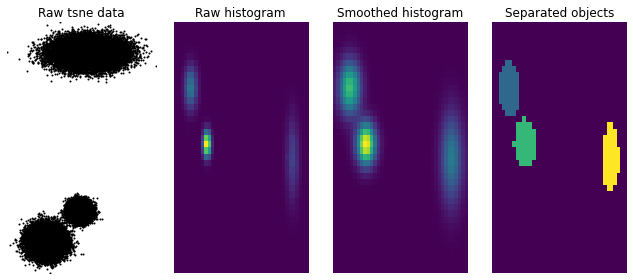

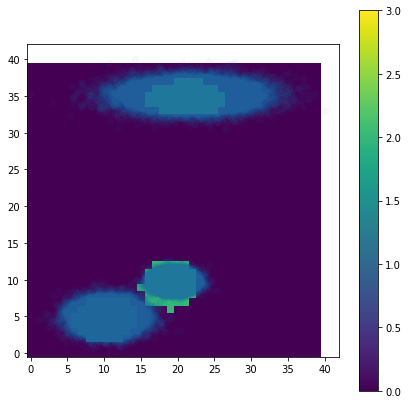

In [1630]:
cluster_sim = run_watershed(simulated_data, 40, 1.75)
simulated_data, cluster_sim = fit_data_to_hist(simulated_data, cluster_sim)

total clusters identified: 16


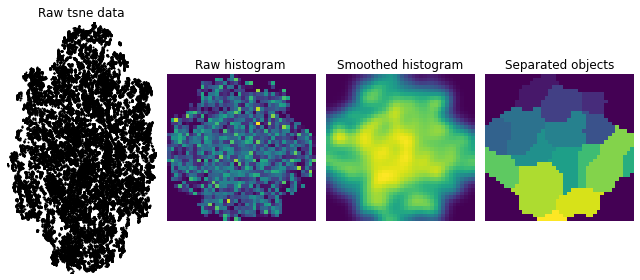

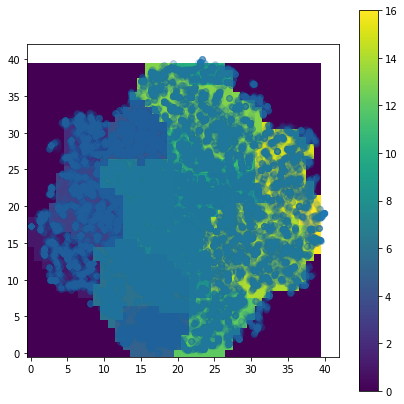

In [1631]:
clusters = run_watershed(tsne_rawdata_nooutliers, 40, 1.75)
tsne_rawdata_nooutliers, clusters_reshaped = fit_data_to_hist(tsne_rawdata_nooutliers, clusters)

In [1632]:
cluster_coord_dict = {}

for i in np.unique(clusters_reshaped):
    if i > 0:
        cluster_coord_dict[i] = np.where(clusters_reshaped == i)

In [1633]:
tsne_rawdata_nooutliers_int = tsne_rawdata_nooutliers.astype(int)


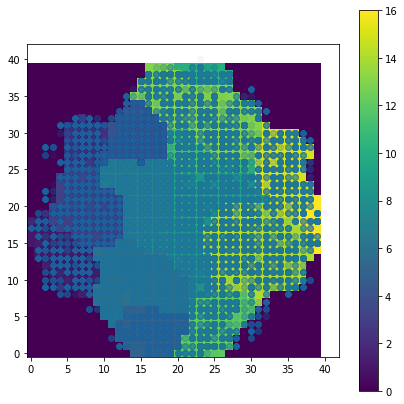

In [1634]:
plt.imshow(clusters_reshaped, origin = 'lower')
plt.colorbar()
plt.scatter(tsne_rawdata_nooutliers_int['coord1'], tsne_rawdata_nooutliers_int['coord2'], alpha = 0.04)

In [1635]:
cluster_key_list = []

for i in range(len(tsne_rawdata_nooutliers_int)):
    case_not_found = True
    for j in cluster_coord_dict.keys():
        if tsne_rawdata_nooutliers_int.iloc[i][0] in cluster_coord_dict[j][1] and tsne_rawdata_nooutliers_int.iloc[i][1] in cluster_coord_dict[j][0]:
           cluster_key_list.append(j)
           case_not_found = False
           break
    if case_not_found:
        cluster_key_list.append('out_of_bounds')

In [1636]:
'concatenate the cluster key list to the original dataframe'
tsne_rawdata_nooutliers['cluster_key'] = cluster_key_list

In [1637]:
#read the original dataframe that has the subject id, frame numbers, and session types

raw_video_data = pd.read_csv('/Users/carlydrzewiecki/Desktop/trainor_cluster/outliersremoved_framesandsubjectids_n59305.csv')

#add the key to this dataframe
all_raw_data = pd.concat([raw_video_data, tsne_rawdata_nooutliers], axis = 1)
all_raw_data = all_raw_data.drop(['Unnamed: 0'], axis = 1)

## SELECT FRAMES FROM THE VIDEOS

In [1638]:
'subset the first 5000 rows of data'
sample_data = all_raw_data.iloc[0:5000]

In [1639]:
subject_array = np.unique(np.array(sample_data['subject_id']))
#put it in a list for good measure because I am anticipating this being easier....
subject_list = []
for i in range(len(subject_array)):
    subject_list.append(subject_array[i])

In [1640]:
print(subject_list)
#note - both the videos are the VP session

[7170, 7211]


In [1641]:
sample_data.head()


,frame,subject_id,session_type,dist_between_mice,intruder_investigation,nose_to_nose_investigation,dist_from_left_wall,test_subject_rearing,intruder_rearing,test_subject_velocity,intruder_velocity,velocity_between_mice,orientation_to_intruder,coord1,coord2,cluster_key
0,986,7211,VP,-0.813703,-0.846966,-0.908127,0.593722,0.505902,0.689271,-0.949160,-0.784054,0.435836,-0.073965,24.572443,5.967497,12
1,987,7211,VP,-0.895208,-0.846760,-0.946324,0.595147,0.530001,0.660558,-0.913947,-0.898449,-0.915054,-0.001066,24.525499,5.972685,12
2,988,7211,VP,-0.925050,-0.835650,-0.917322,0.596755,0.427097,0.696642,-0.742137,-0.918265,-0.355152,0.126856,24.469022,5.993481,12
3,989,7211,VP,-0.948173,-0.821737,-0.865325,0.628133,0.256207,0.735331,-0.809422,-0.980344,-0.282331,0.234743,24.403616,6.037412,12
4,990,7211,VP,-0.975764,-0.816396,-0.860016,0.632587,0.234951,0.716237,-0.793552,-0.987932,-0.330759,0.762863,24.288078,6.148766,12


## Rename all the video files

In [1642]:
# #this should be revisited eventually when you have all the videos in the same directory
# ##so it's getting taken out for now

# video_dir = Path('/Users/carlydrzewiecki/Desktop/trainor_cluster/videos/')
# raw_videos = glob.glob(str(video_dir/'*.avi'))
# for i in range(len(raw_videos)):
#     'write the new filenames to the directory'
#     os.rename(raw_videos[i], raw_videos[i].replace(',', '').replace(' ', '_'))


In [1725]:
##subsetting the two videos for the sample dataset above
video_dir = Path('/Users/carlydrzewiecki/Desktop/trainor_cluster/videos/')
sample_vids = glob.glob(str(video_dir/'*.avi'))

## Reformatting the data to be organized by each unique cluster

In [1530]:
n_frames_without_cluster = len(sample_data[sample_data['cluster_key'] == 'out_of_bounds'])
print(f'there are {n_frames_without_cluster} frames without a cluster')
'remove the frames without a cluster'
sample_data = sample_data[sample_data['cluster_key'] != 'out_of_bounds']

there are 16 frames without a cluster


In [1455]:
cluster_df_list = []

'create a new dataframe for each unique cluster_key'
for i in np.unique(sample_data['cluster_key']):
    if i > 0:
        globals()['cluster_%s' % i] = sample_data[sample_data['cluster_key'] == i]
    'append all the new dataframes to a list'
    cluster_df_list.append(globals()['cluster_%s' % i])


In [1458]:
for i in range(len(cluster_df_list)):
    print(f'there are {len(cluster_df_list[i])} frames in cluster {i+1}')

there are 691 frames in cluster 1
there are 263 frames in cluster 2
there are 1088 frames in cluster 3
there are 241 frames in cluster 4
there are 57 frames in cluster 5
there are 671 frames in cluster 6
there are 456 frames in cluster 7
there are 218 frames in cluster 8
there are 185 frames in cluster 9
there are 45 frames in cluster 10
there are 601 frames in cluster 11
there are 435 frames in cluster 12
there are 33 frames in cluster 13


In [1590]:
#Randomly select frames from each cluster
frames_to_select = 20

random_samples = []

for cluster_df in cluster_df_list:
    cluster_df_random_samples = cluster_df.sample(n = frames_to_select)
    random_samples.append(cluster_df_random_samples)

In [1591]:
for i in range(len(random_samples)):
    print(f'there are {len(random_samples[i])} frames in cluster {i+1}')

there are 20 frames in cluster 1
there are 20 frames in cluster 2
there are 20 frames in cluster 3
there are 20 frames in cluster 4
there are 20 frames in cluster 5
there are 20 frames in cluster 6
there are 20 frames in cluster 7
there are 20 frames in cluster 8
there are 20 frames in cluster 9
there are 20 frames in cluster 10
there are 20 frames in cluster 11
there are 20 frames in cluster 12
there are 20 frames in cluster 13


In [1592]:
random_samples[0].head()


,frame,subject_id,session_type,dist_between_mice,intruder_investigation,nose_to_nose_investigation,dist_from_left_wall,test_subject_rearing,intruder_rearing,test_subject_velocity,intruder_velocity,velocity_between_mice,orientation_to_intruder,coord1,coord2,cluster_key
4989,4845,7170,VP,0.582220,-0.692017,0.061256,0.967114,0.821775,0.425964,-0.929820,-0.936645,0.275620,0.899689,7.041188,9.684687,1
2095,3632,7211,VP,0.475496,0.485450,0.455821,0.667319,0.596362,0.696175,-0.990986,-0.954182,-0.040267,-0.670407,5.941385,19.971203,1
4838,4234,7170,VP,0.150376,-0.716148,-0.180267,0.607911,0.657248,0.488317,-0.944201,-0.800507,-0.152033,0.767083,6.931541,9.339576,1
2093,3629,7211,VP,0.483379,0.481656,0.452880,0.664525,0.563239,0.692003,-0.997119,-0.994201,-0.018775,-0.691018,5.926923,19.974708,1
4980,4834,7170,VP,0.136345,-0.341720,-0.226126,0.561730,0.931526,0.578373,-0.944496,-0.915911,0.127611,0.753789,6.713234,9.277159,1


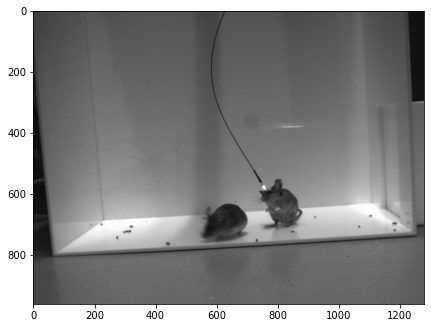

frame number 5796 from subject 7211 in cluster 12


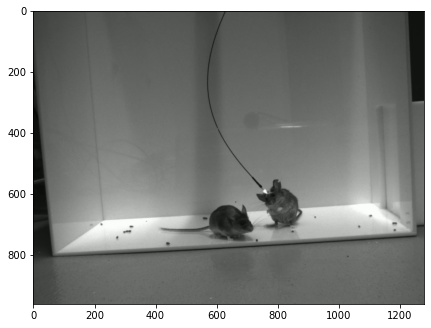

frame number 5755 from subject 7211 in cluster 12


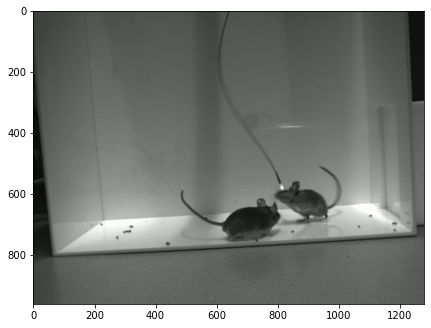

frame number 5519 from subject 7211 in cluster 12


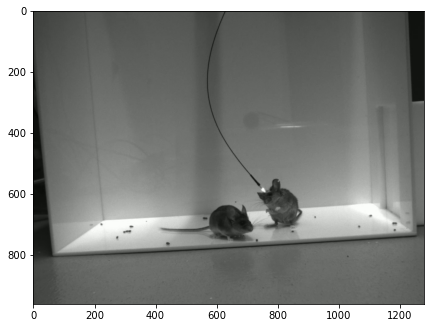

frame number 5724 from subject 7211 in cluster 12


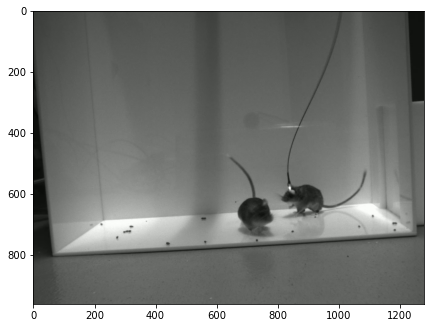

frame number 6246 from subject 7211 in cluster 12


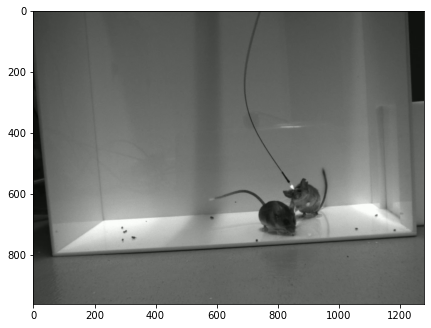

frame number 1478 from subject 7211 in cluster 12


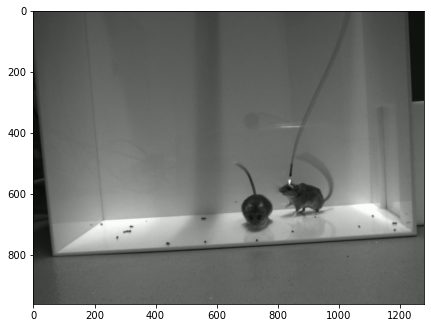

frame number 6241 from subject 7211 in cluster 12


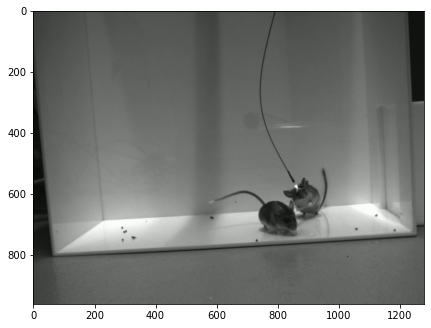

frame number 1504 from subject 7211 in cluster 12


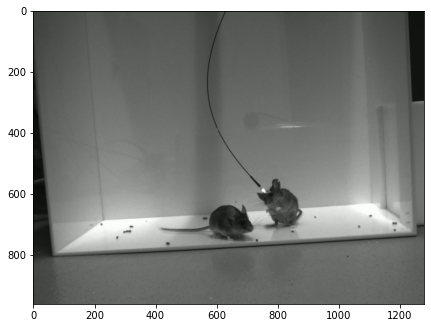

frame number 5743 from subject 7211 in cluster 12


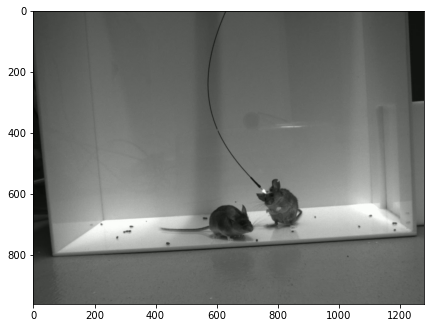

frame number 5746 from subject 7211 in cluster 12


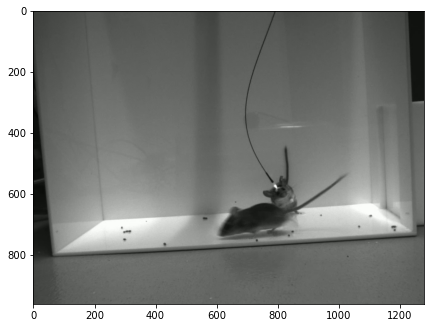

frame number 4294 from subject 7211 in cluster 12


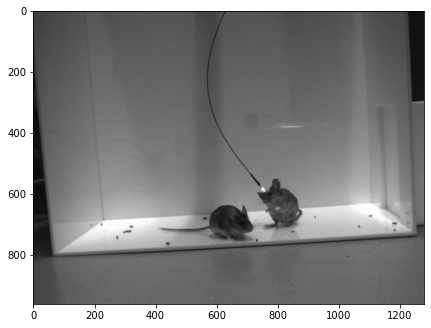

frame number 5719 from subject 7211 in cluster 12


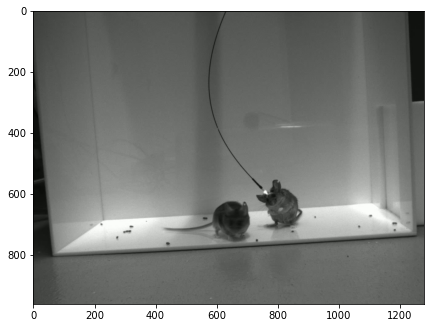

frame number 5787 from subject 7211 in cluster 12


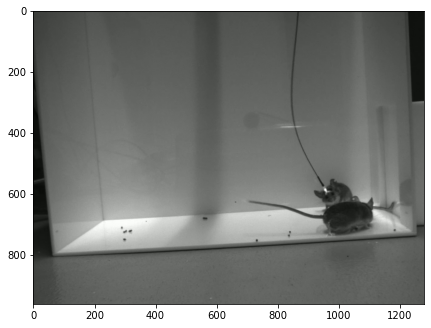

frame number 2991 from subject 7211 in cluster 12


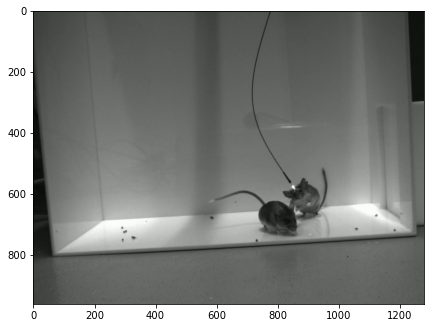

frame number 1489 from subject 7211 in cluster 12


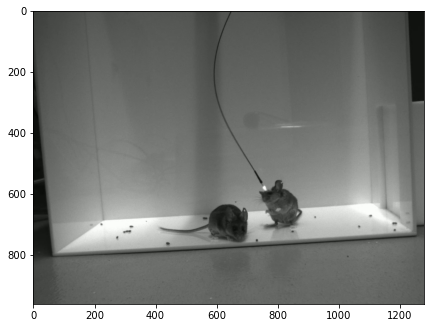

frame number 5675 from subject 7211 in cluster 12


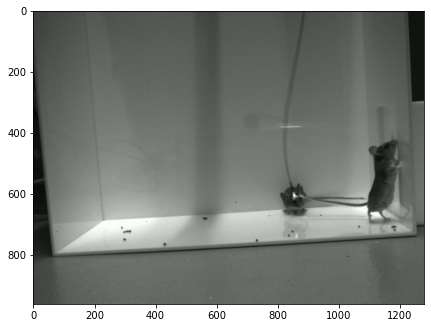

frame number 4223 from subject 7211 in cluster 12


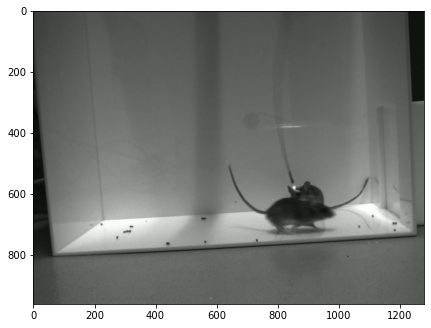

frame number 6256 from subject 7211 in cluster 12


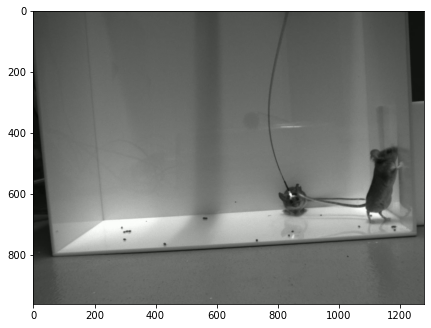

frame number 4226 from subject 7211 in cluster 12


In [1723]:
#for i in range(len(random_samples)):
for i in [11]:
    for j in range(len(random_samples[i])):
        if random_samples[i].iloc[j]['subject_id'] == 7211:
            #print(random_samples[i].iloc[j]['frame'])
            plt.imshow(mpe.VideoFileClip(sample_vids[0]).get_frame((random_samples[i].iloc[j]['frame'])/30))
            plt.show()
            print(f'frame number {random_samples[i].iloc[j]["frame"]} from subject {random_samples[i].iloc[j]["subject_id"]} in cluster {i+1}')

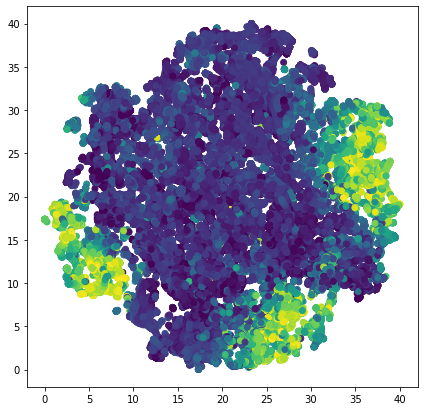

In [1749]:
#plt.scatter(all_raw_data['coord1'], all_raw_data['coord2'], c = all_raw_data['dist_between_mice'])
plt.scatter(all_raw_data['coord1'], all_raw_data['coord2'], c = all_raw_data['orientation_to_intruder'])

In [1727]:
all_raw_data.columns

Index(['frame', 'subject_id', 'session_type', 'dist_between_mice',
       'intruder_investigation', 'nose_to_nose_investigation',
       'dist_from_left_wall', 'test_subject_rearing', 'intruder_rearing',
       'test_subject_velocity', 'intruder_velocity', 'velocity_between_mice',
       'orientation_to_intruder', 'coord1', 'coord2', 'cluster_key'],
      dtype='object')

In [1748]:
#plt.scatter(all_raw_data['coord1'], all_raw_data['coord2'], c = all_raw_data['orientation_to_intruder'])

In [1744]:
def fit_data_to_hist_withcolormap(tsne_raw_data, watershed_hist, colormap_column):
    'rotate clusters 90 degrees and flip along the y axis'
    clusters_rotated = np.rot90(watershed_hist, 3)
    clusters_rotated_flipped = np.flip(clusters_rotated, 1)
    "shifting the tsne data so that the minimum value is at 0, 0"
    tsne_raw_data['coord1'] = tsne_raw_data['coord1'] - (tsne_raw_data['coord1'].min())
    tsne_raw_data['coord2'] = tsne_raw_data['coord2'] - (tsne_raw_data['coord2'].min())
    "apply a linear transformation so that simulated data fits a the same size as the histogram"
    tsne_raw_data['coord1'] = tsne_raw_data['coord1'] * clusters_rotated_flipped.shape[0] / (tsne_raw_data['coord1'].max() - tsne_raw_data['coord1'].min())
    tsne_raw_data['coord2'] = tsne_raw_data['coord2'] * clusters_rotated_flipped.shape[0] / (tsne_raw_data['coord2'].max() - tsne_raw_data['coord2'].min())
    'plot everything to see if we did this correctly'
    plt.imshow(clusters_rotated_flipped, origin = 'lower', cmap='gray')
    #plt.colorbar()
    plt.scatter(tsne_raw_data['coord1'], tsne_raw_data['coord2'], alpha = 0.04, c = colormap_column)
    return tsne_raw_data, clusters_rotated_flipped  

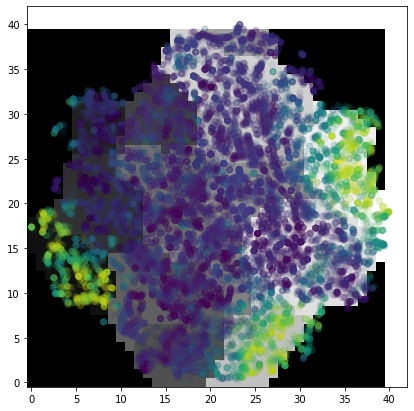

In [1746]:
aa, bb = fit_data_to_hist_withcolormap(all_raw_data, clusters, all_raw_data['orientation_to_intruder'])

In [1747]:
#all_raw_data.columns